In [1]:
import numpy as np
import bayespy as bp
from matplotlib import pyplot as plt, rcParams
from matplotlib import style
from matplotlib import cm
from matplotlib import ticker
import scipy.stats
import os
import json
from tqdm import tqdm_notebook
import multiprocessing
import functools as ft
import importlib
import time_series
importlib.reload(time_series)
from time_series import *

%matplotlib inline
style.use('../figures/scrartcl.mplstyle')

In [2]:
hyperparameters = os.environ.get('HYPERPARAMETERS')
if hyperparameters:
    with open(hyperparameters) as fp:
        hyperparameters = json.load(fp)
else:
    hyperparameters = {
        'rho/concentration': 1e-3,
        'Lambda/shape': 0.0,     # We will add on the dimensionality of the space
        'Lambda/scale': list(10.0 ** np.arange(-5, 4, 0.5)),  # We will multiply by the identity matrix and the dimension
        'tau/shape': 1e-3,
        'tau/scale': 1e-3,
        'lambda/shape': 1e-5,
        'lambda/scale': 1e-5,
        'ard_prior': 'independent',
        'num_groups': 20,
        'num_factors': 2,
        'seed': [2, 3, 4, 5],
        'tolerance': 1e-6,
        'initialization': 'kmeans',
    }
    
print(json.dumps(hyperparameters, indent=4))

{
    "rho/concentration": 0.001,
    "Lambda/shape": 0.0,
    "Lambda/scale": [
        1e-05,
        3.1622776601683795e-05,
        0.0001,
        0.00031622776601683794,
        0.001,
        0.0031622776601683794,
        0.01,
        0.03162277660168379,
        0.1,
        0.31622776601683794,
        1.0,
        3.1622776601683795,
        10.0,
        31.622776601683793,
        100.0,
        316.22776601683796,
        1000.0,
        3162.2776601683795
    ],
    "tau/shape": 0.001,
    "tau/scale": 0.001,
    "lambda/shape": 1e-05,
    "lambda/scale": 1e-05,
    "ard_prior": "independent",
    "num_groups": 20,
    "num_factors": 2,
    "seed": [
        2,
        3,
        4,
        5
    ],
    "tolerance": 1e-06,
    "initialization": "kmeans"
}


In [3]:
np.random.seed(hyperparameters['seed'][0])
num_nodes = 50
num_obs = 100
concentration = 1e3

In [4]:
mu = []
for i in range(3):
    x = 2 * np.pi * i / 3 - np.pi / 6
    x = 3 * np.asarray([np.cos(x), np.sin(x)])
    for j in range(3):
        y = 2 * np.pi * j / 3 - np.pi / 6
        y = np.asarray([np.cos(y), np.sin(y)])
        mu.append(x + y)
mu = np.asarray(mu)

num_groups, num_factors = mu.shape

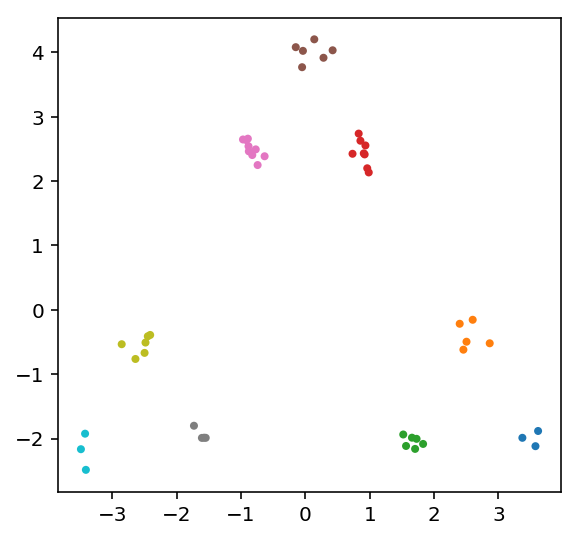

In [5]:
Lambda = scipy.stats.wishart.rvs(50, np.eye(num_factors), num_groups)
rho = np.random.dirichlet(concentration * np.ones(num_groups))
idx = np.random.choice(num_groups, num_nodes, p=rho)
z = np.ones((num_nodes, num_groups))
z[np.arange(num_nodes), idx] = 1
A = mu[idx] + np.einsum('ijk,ik->ij', np.linalg.cholesky(np.linalg.inv(Lambda))[idx], 
                        np.random.normal(0, 1, (num_nodes, num_factors)))
x = np.random.normal(0, 1, (num_obs, num_factors))
predictor = np.dot(x, A.T)
tau = np.random.gamma(100, 1 / 10, num_nodes)
y = predictor + np.random.normal(0, 1 / np.sqrt(tau), (num_obs, num_nodes))

fig, ax = plt.subplots()
ax.scatter(*A.T, c=idx, cmap='tab10', marker='.')
ax.set_aspect(1)

In [6]:
variables, list_params = build_parameters(hyperparameters)
params = list_params[20]
params

{'Lambda/scale': 0.0031622776601683794,
 'Lambda/shape': 0.0,
 'ard_prior': 'independent',
 'initialization': 'kmeans',
 'lambda/scale': 1e-05,
 'lambda/shape': 1e-05,
 'num_factors': 2,
 'num_groups': 20,
 'rho/concentration': 0.001,
 'seed': 2,
 'tau/scale': 0.001,
 'tau/shape': 0.001,
 'tolerance': 1e-06}

created model in 0.013
fitted embedding in 0.220
lowerbound: -2955.149943
created community model in 0.017
lowerbound: -2002894.952024
initialized kmeans in 0.083
fitted GMM in 0.081
lowerbound: -3437.636598


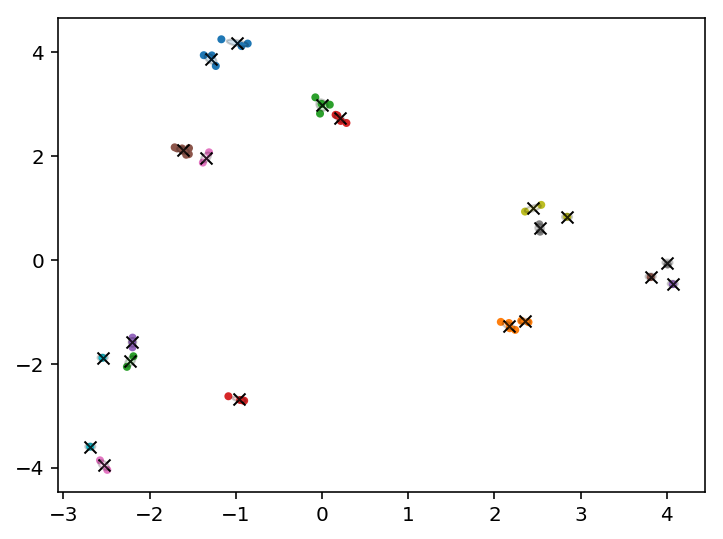

In [7]:
Q = fit_model(y, params, A=A, steps=(0, 1, 2, 3), verbose=True)
plot_mixture(Q)

In [8]:
with multiprocessing.Pool() as pool:
    models = list(tqdm_notebook(pool.imap(ft.partial(fit_model, y, steps=5), list_params), total=len(list_params)))

HBox(children=(IntProgress(value=0, max=72), HTML(value='')))

In [9]:
shape = [len(value) for value in variables.values()]
lowerbounds = np.reshape([Q.compute_lowerbound() for Q in models], shape)
best_lowerbounds = np.max(lowerbounds, axis=1)

num_clusters = np.reshape([len(set(np.argmax(Q['z'].get_moments()[0], axis=1))) for Q in models], shape)
best_num_clusters = num_clusters[np.arange(len(num_clusters)), np.argmax(lowerbounds, axis=1)]

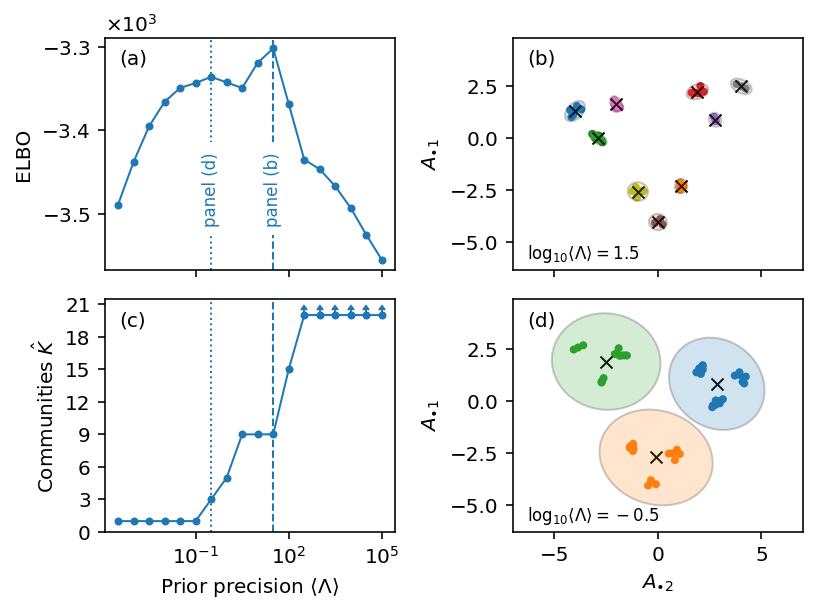

In [73]:
from matplotlib import colors as mcolors

scales = np.asarray(hyperparameters['Lambda/scale'])
prior_precision = 1 / scales
fig, axes = plt.subplots(2, 2, sharex='col')
((ax1, ax2), (ax3, ax4)) = axes

# show the evidence lower bound
ax1.plot(prior_precision, best_lowerbounds, marker='.')
ax1.set_xscale('log')
ax1.set_ylabel('ELBO')
ax1.yaxis.major.formatter.set_powerlimits((0, 0))
ax1.yaxis.major.formatter._useMathText = True

# Show the number of clusters
f = best_num_clusters == hyperparameters['num_groups']
ax3.errorbar(prior_precision, best_num_clusters, np.where(f, 0.5, 0), marker='.', lolims=f, capsize=1.5)
ax3.set_xlabel(r'Prior precision $\left\langle \Lambda\right\rangle$')
ax3.set_ylabel(r'Communities $\hat K$')
ax3.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

best = np.argmax(best_lowerbounds)
for ax in [ax1, ax3]:
    ax.axvline(prior_precision[best], ls='--')
    ax.axvline(prior_precision[best + 4], ls=':')
    
kwargs = dict(color='C0', fontsize='small', rotation=90, ha='center', 
              va='center', backgroundcolor='w')
ax1.text(prior_precision[best], -3.47e3, 'panel (b)', **kwargs)
ax1.text(prior_precision[best + 4], -3.47e3, 'panel (d)', **kwargs)
    
# Show the inferred clusters
ax2.get_shared_x_axes().join(ax2, ax4)
Qs = np.reshape(models, shape)
idx = [best, best + 4]
for ax, i in zip([ax2, ax4], idx):
    Q = max(Qs[i], key=lambda x: x.compute_lowerbound())
    ax.set_aspect(1)
    labels = evaluate_labels(Q)
    cmap = mcolors.ListedColormap(['C%d' % i for i in range(len(set(labels)))])
    plot_mixture(Q, ax, scale=5, cmap=cmap)
    ax.text(0.05, 0.05, r'$\log_{10}\left\langle\Lambda\right\rangle=%.1f$' % np.log10(prior_precision[i]), 
            transform=ax.transAxes, fontsize='small')
            
    ax.set_ylabel(r'$A_{\bullet 1}$')
    
ax4.set_xlabel(r'$A_{\bullet 2}$')
            
ax.set_xlim(-7, 7)
label_axes(axes)

fig.tight_layout()

fig.savefig('../figures/multiscale.pdf')
fig.savefig('../figures/multiscale.png')

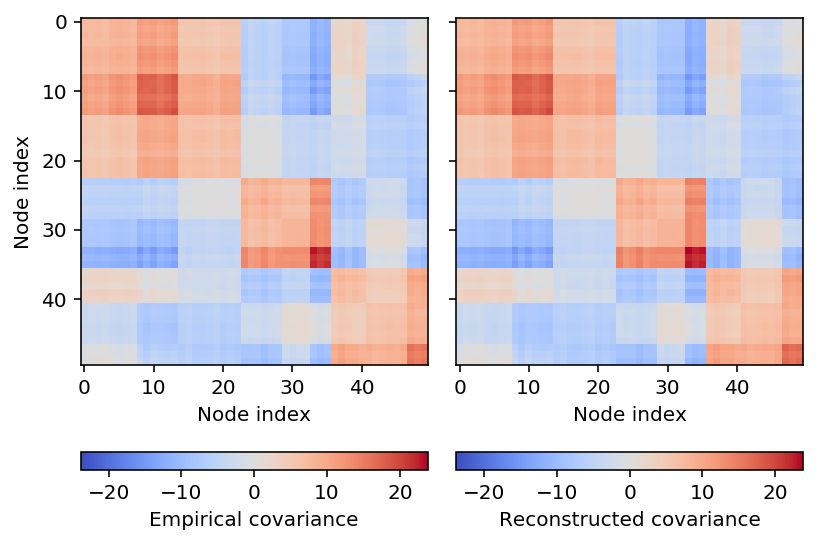

In [11]:
Q = max(models, key=lambda x: x.compute_lowerbound())
_A = Q['A'].get_moments()[0]
_z = Q['z'].get_moments()[0]
i = get_best_permutation(_A, _z)

fig, axes = plt.subplots(1, 2, True, True)

cov = np.cov(y.T)

reconstructed = np.dot(_A, _A.T)  + np.diag(1 / Q['tau'].get_moments()[0])

covs =[cov, reconstructed]
vmax = np.max(np.abs(covs))

for ax, c, name in zip(axes, covs, ['Empirical covariance', 'Reconstructed covariance']):
    mappable = ax.imshow(c[i][:, i], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
    cb.set_label(name)
    ax.set_adjustable('box-forced')
    ax.set_xlabel('Node index')
axes[0].set_ylabel('Node index')

fig.tight_layout()
fig.savefig('../figures/multiscale-covariance.pdf')
fig.savefig('../figures/multiscale-covariance.png')

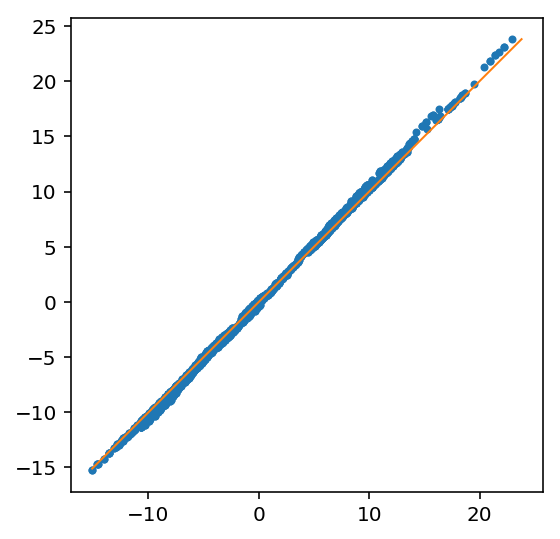

In [12]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(cov.ravel(), reconstructed.ravel())
mm = np.min(cov), np.max(reconstructed)
ax.plot(mm, mm, color='C1')